<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
%matplotlib inline
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'C:/Users/oorzhak/Desktop/Coursera/C6/Ident_user/W3/capstone_user_identification/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as SFD_pkl:
        SiteFreqDict = pickle.Unpickler(SFD_pkl).load()
    
    l = glob(path_to_csv_files+'/*.csv')
    ListDataRes = []
    
    for i, NameCsvFile in tqdm(enumerate(l)):
        user_x = pd.read_csv(NameCsvFile, sep = ',', header = 0)
        user_x['index'] = user_x['site'].map(lambda x: SiteFreqDict[x][0])
        StackSites = user_x['index']
        SessionTimespan = user_x['timestamp'].apply(pd.to_datetime)
        k = 0
        ListData = []

        while (k*window_size) < len(StackSites):
            ListData.append([])
            for j in range(session_length):
                if (k*window_size+j) < len(StackSites):
                    ListData[k].append(StackSites[k*window_size+j])
                else:
                    ListData[k].append(0)
            for j in range(1, session_length):
                if (k*window_size+j) < len(SessionTimespan):
                    ListData[k].append(pd.Timedelta(SessionTimespan[k*window_size+j]-
                                                    SessionTimespan[k*window_size+j-1]).seconds)
                else:
                    ListData[k].append(0)
            if (k*window_size+session_length) <= len(SessionTimespan):
                ListData[k].append(pd.Timedelta(SessionTimespan[k*window_size+session_length-1]
                                                -SessionTimespan[k*window_size]).seconds)
                ListData[k].append(StackSites[k*window_size:(k*window_size+session_length)].unique().size)
                ListData[k].append(SessionTimespan[k*window_size].hour)
                ListData[k].append(SessionTimespan[k*window_size].weekday())
            else:
                ListData[k].append(pd.Timedelta(SessionTimespan.iloc[-1]
                                                -SessionTimespan[k*window_size]).seconds)
                ListData[k].append(StackSites[k*window_size:len(StackSites)].unique().size)
                ListData[k].append(SessionTimespan[k*window_size].hour)
                ListData[k].append(SessionTimespan[k*window_size].weekday())                  
            
            ListData[k].append(int(NameCsvFile[-7:-4]))
            k+=1
            
        ListDataRes += ListData
        
    DataRes = pd.DataFrame(ListDataRes, columns=feature_names)
                    
    return DataRes

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

3it [00:00, 17.54it/s]


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,4,2,2,9,2,1,11,6,10,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,7,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

10it [00:38,  3.93s/it]


Wall time: 39.3 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,193,575,134,3,134,134,3,134,203,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,417,192,698,254,134,31,396,3673,221,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,294,417,336,912,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,476,3875,476,55,55,55,55,965,202,124,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,344,55,5,3667,258,211,4046,2323,697,2323,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [ ]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

102it [04:24,  3.93s/it]

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [ ]:
new_features_10users = train_data_10users.iloc[:,-5:-1].values
new_features_150users = train_data_150users.iloc[:,-5:-1].values

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
d = {}
for user_x in train_data_10users['user_id'].unique():
    d[user_x] =np.median(train_data_10users[train_data_10users['user_id'] == user_x]['session_timespan'])

<BarContainer object of 10 artists>

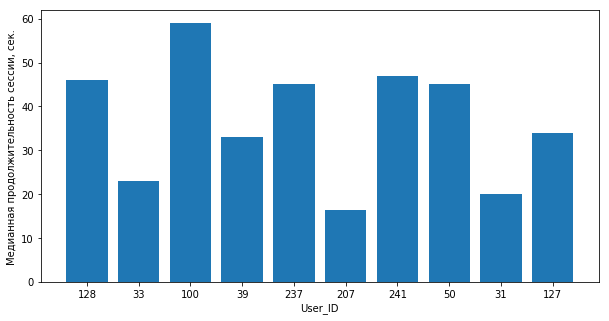

In [18]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.xlabel(u'User_ID')
plt.ylabel(u'Медианная продолжительность сессии, сек.')
plt.bar(map(str,d.keys()), d.values())

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [19]:
d = {}
for user_x in train_data_10users['user_id'].unique():
    d[user_x] =int(np.median(train_data_10users[train_data_10users['user_id'] == user_x]['day_of_week']))

<BarContainer object of 10 artists>

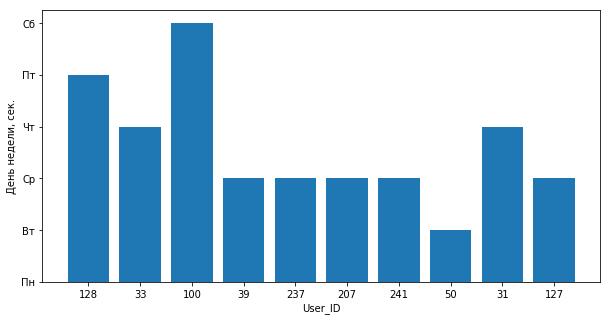

In [20]:
fig, axes = plt.subplots(figsize=(10, 5))

days_of_week = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']
axes.set_yticks(range(7))
axes.set_yticklabels(days_of_week)
plt.xlabel(u'User_ID')
plt.ylabel(u'День недели, сек.')

plt.bar(map(str,d.keys()), d.values())

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [21]:
d = {}
for user_x in train_data_150users['user_id'].unique():
    d[user_x] =int(np.median(train_data_150users[train_data_150users['user_id'] == user_x]['start_hour']))

<BarContainer object of 148 artists>

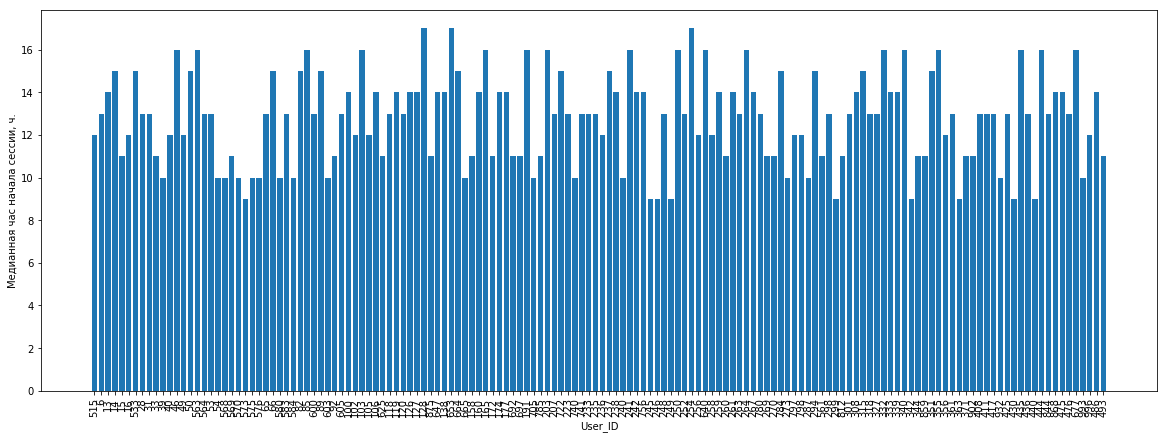

In [22]:
fig, axes = plt.subplots(figsize=(20, 7))

plt.ylabel(u'Медианная час начала сессии, ч.')
plt.xlabel(u'User_ID')
plt.xticks(fontsize=10, rotation=90)

plt.bar(map(str,d.keys()), d.values(), width=0.8)

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [23]:
d = {}
for user_x in train_data_150users['user_id'].unique():
    d[user_x] =int(np.median(train_data_150users[train_data_150users['user_id'] == user_x]['#unique_sites']))

<BarContainer object of 148 artists>

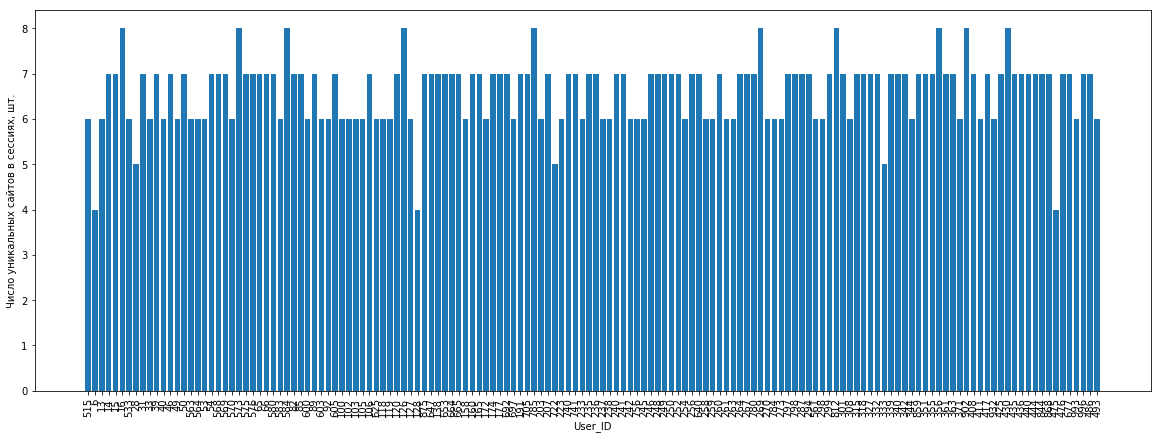

In [24]:
fig, axes = plt.subplots(figsize=(20, 7))

plt.ylabel(u'Число уникальных сайтов в сессиях, шт.')
plt.xlabel(u'User_ID')
plt.xticks(fontsize=10, rotation=90)

plt.bar(map(str,d.keys()), d.values(), width=0.8)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [25]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [26]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

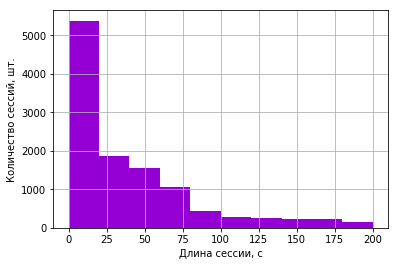

In [27]:
plt.xlabel(u'Длина сессии, с')
plt.ylabel(u'Количество сессий, шт.')
train_data_10users['session_timespan'].loc[train_data_10users['session_timespan'] <= 200].hist(color="darkviolet")

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

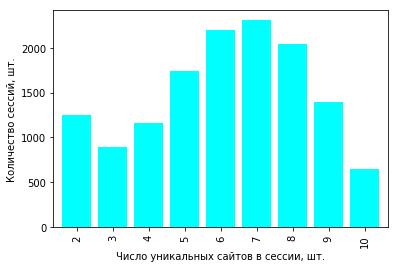

In [28]:
plt.xlabel(u'Число уникальных сайтов в сессии, шт.')
plt.ylabel(u'Количество сессий, шт.')
df = train_data_10users['#unique_sites']
df.value_counts().sort_index()[1:].plot.bar(width=0.8, color="aqua")

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

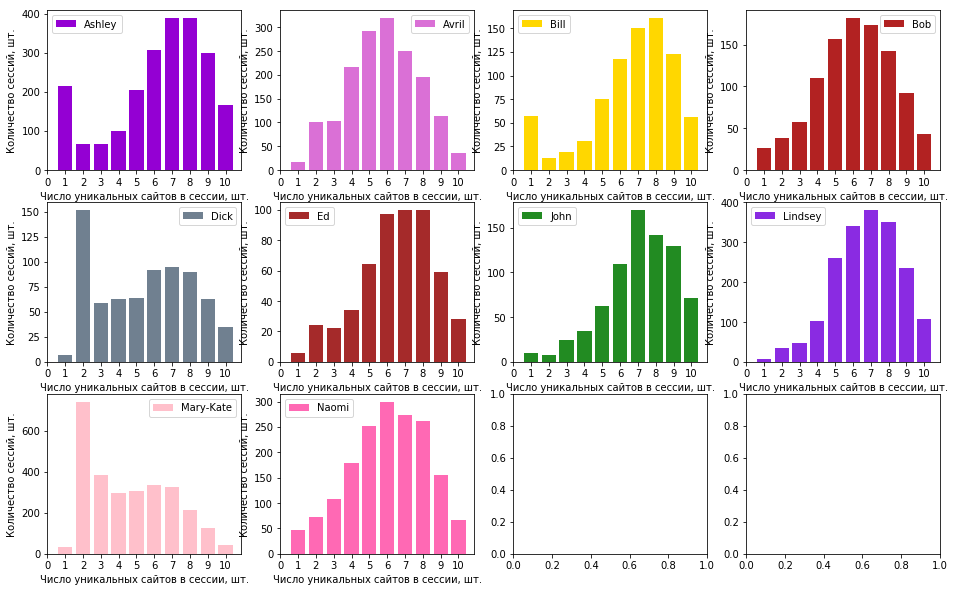

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_data_10users, 'user_id')): 
    axes[idx // 4][idx % 4].bar(sub_df['#unique_sites'].value_counts().index, sub_df['#unique_sites'].value_counts(), 
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].legend()
    axes[idx // 4][idx % 4].set_xlabel(u'Число уникальных сайтов в сессии, шт.')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].set_xticks([i for i in range(11)])
    axes[idx // 4][idx % 4].set_xticklabels([i for i in range(11)])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

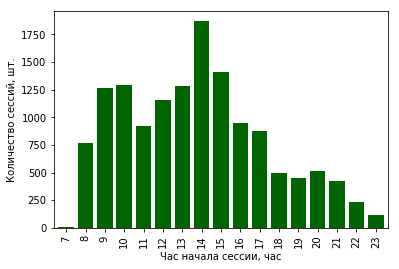

In [26]:
plt.xlabel(u'Час начала сессии, час')
plt.ylabel(u'Количество сессий, шт.')
df = train_data_10users['start_hour']
df.value_counts().sort_index().plot.bar(width=0.8, color="darkgreen")

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

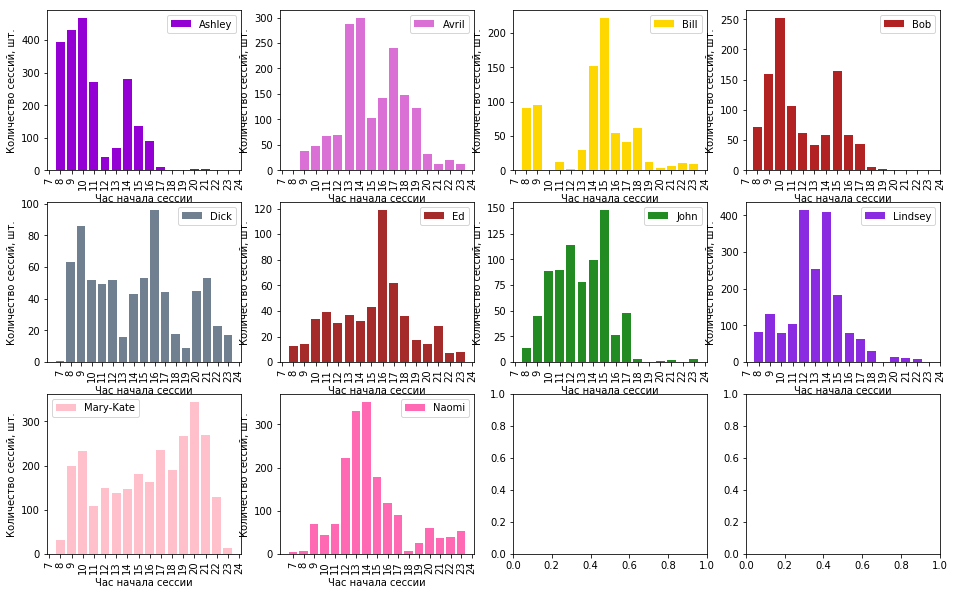

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_data_10users, 'user_id')): 
    axes[idx // 4][idx % 4].bar(sub_df['start_hour'].value_counts().index, sub_df['start_hour'].value_counts(),
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].legend()
    axes[idx // 4][idx % 4].set_xlabel(u'Час начала сессии')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].set_xticks([i for i in range(7,25)])
    axes[idx // 4][idx % 4].set_xticklabels([i for i in range(7,25)], rotation=90)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

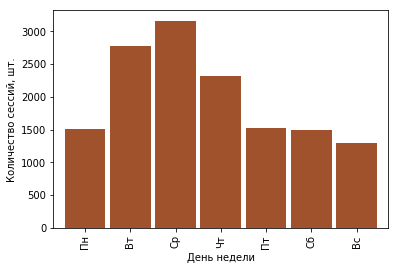

In [31]:
plt.xlabel(u'День недели')
plt.ylabel(u'Количество сессий, шт.')
days_of_week = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

train_data_10users['day_of_week'].value_counts().sort_index().plot.bar(color="sienna", width=0.9)

locs, labels = xticks(np.arange(7), days_of_week)

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

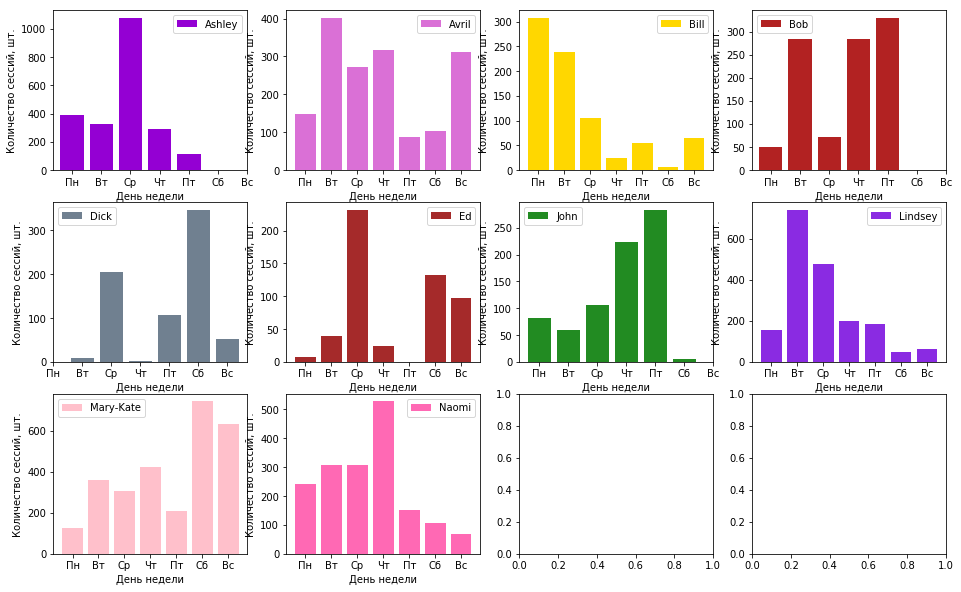

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
days_of_week = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_data_10users, 'user_id')): 
    axes[idx // 4][idx % 4].bar(sub_df['day_of_week'].value_counts().index, sub_df['day_of_week'].value_counts(), 
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].set_xlabel(u'День недели')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].set_xticks(range(7))
    axes[idx // 4][idx % 4].set_xticklabels(days_of_week)
    axes[idx // 4][idx % 4].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

#### User № 39 Ashley

Пользователь ID 39 за сессию преимущественно посещяет свыше 6 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 7, 8 (в абс. величинах – порядка 400 сессий);
    <li>с наименьший частотой – 2, 3 (в абс. величинах – менее 100 сессий).
</ul>
Интервал работы с интернетом с 8 до 17 ч. Наибольшая активность приурочена к интервалам с 8 до 11 ч. и с 14 до 16 ч. Максимальная актиность в 10 ч. (в абс. величинах – порядка 450 сессий), минимальная - в 17 ч. (в абс. величинах – менее 10 сессий).
Наибольшая активность пользования интернетом в течении недели приходится на среду (в абс. величинах – более 1000 сессий), наименьшая – на пятницу (в абс. величинах – порядка 100 сессий). Суббота и воскресенье – дни с отсутствием активности.

#### User №237 Avril

Пользователь ID 237 за сессию преимущественно посещяет свыше 4 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 6 (в абс. величинах – порядка 300 сессий);
    <li>с наименьший частотой – 1 (в абс. величинах – менее 25 сессий).
</ul>
Интервал работы с интернетом с 9 до 23 ч. Наибольшая активность приурочена к интервалам с 13 до 14 ч. и с 16 до 19 ч. Максимальная актиность в 14 ч. (в абс. величинах – порядка 300 сессий), минимальная - в 21 ч. (в абс. величинах – порядка 20 сессий).
На протяжении всей недели пользователь использует интернет. Наибольшая активность пользования интернетом в течении недели приходится на вторник (в абс. величинах – более 400 сессий), наименьшая – на пятницу (в абс. величинах – порядка 90 сессий). 

#### User № 50 Bill

Пользователь ID 50 за сессию преимущественно посещяет свыше 5 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 8 (в абс. величинах – порядка 150 сессий);
    <li>с наименьший частотой – 2 (в абс. величинах – менее 15 сессий).
</ul>
Интервал работы с интернетом с 8 до 23 ч. Наибольшая активность приурочена к интервалам с 8 до 9 ч. и с 14 до 18 ч. Низкая активность приурочена к интервалам с 10 до 12 ч. и с 19 до 23 ч. Максимальная актиность в 15 ч. (в абс. величинах – порядка 220 сессий), минимальная - в 10, 12 и 20 ч (в абс. величинах – менее 10 сессий).
На протяжении всей недели пользователь использует интернет. Наибольшая активность пользования интернетом в течении недели приходится на понедельник (в абс. величинах – порядка 300 сессий), наименьшая – на субботу (в абс. величинах – порядка 10 сессий).

#### User № 33 Bob

Пользователь ID 33 за сессию преимущественно посещяет свыше 4 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 6 (в абс. величинах – порядка 170 сессий);
    <li>с наименьший частотой – 1 (в абс. величинах – менее 25 сессий).
</ul>
Интервал работы с интернетом с 8 до 19 ч. Наибольшая активность приурочена к интервалам с 9 до 11 ч. и в 15 ч. Низкая активность приурочена к 13 ч. и с 16 до 19 ч. Максимальная актиность в 10 ч. (в абс. величинах – порядка 250 сессий), минимальная - в 19 ч. (в абс. величинах – менее 10 сессий).
Наибольшая активность пользования интернетом в течении недели приходится на пятницу (в абс. величинах – порядка 320 сессий), наименьшая – на понедельник (в абс. величинах – порядка 50 сессий). Суббота и воскресенье – дни с отсутствием активности.

#### User № 100 Dick

Пользователь ID 100 за сессию преимущественно посещяет свыше 5 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 2 (в абс. величинах – порядка 150 сессий);
    <li>с наименьший частотой – 1 (в абс. величинах – менее 10 сессий).
</ul>
Интервал работы с интернетом с 8 до 23 ч. Наибольшая активность приурочена к интервалам с 8 до 12 ч., с 14 до 17 ч., с 20 до 22 ч. Низкая активность приурочена к 13 ч. и с 18 до 19 ч. Максимальная актиность в 16 ч. (в абс. величинах – порядка 90 сессий), минимальная - в 19 ч. (в абс. величинах – порядка 10 сессий).
Наибольшая активность пользования интернетом в течении недели приходится на субботу (в абс. величинах – более 330 сессий), наименьшая – на четверг (в абс. величинах – менее 10 сессий). В понедельник отсутствует активность.

#### User № 241 Ed

Пользователь ID 241 за сессию преимущественно посещяет свыше 4 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 7, 8 (в абс. величинах – порядка 100 сессий);
    <li>с наименьший частотой – 1 (в абс. величинах – менее 10 сессий).
</ul>
Интервал работы с интернетом с 8 до 23 ч. Наибольшая активность приурочена к интервалу с 15 до 17 ч. Низкая активность приурочена с 8 до 9 ч. и с 22 до 23 ч. Максимальная актиность в 16 ч. (в абс. величинах – порядка 120 сессий), минимальная - в 22 ч. (в абс. величинах – менее 10 сессий).
Наибольшая активность пользования интернетом в течении недели приходится на среду (в абс. величинах – более 220 сессий), наименьшая – на понедельник (в абс. величинах – менее 10 сессий). В пятницу отсутствует активность.

#### User № 31 John

Пользователь ID 31 за сессию преимущественно посещяет свыше 5 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 7 (в абс. величинах – порядка 160 сессий);
    <li>с наименьший частотой – 2 (в абс. величинах – порядка 10 сессий).
</ul>
Интервал работы с интернетом с 8 до 23 ч. Наибольшая активность приурочена к интервалу с 10 до 17 ч. Низкая активность приурочена к 8 ч. и с 18 до 23 ч. Максимальная актиность в 15 ч. (в абс. величинах – порядка 150 сессий), минимальная - в 19, 22 ч. (в абс. величинах – менее 10 сессий).
Наибольшая активность пользования интернетом в течении недели приходится на пятницу (в абс. величинах – порядка 260 сессий), наименьшая – на субботу (в абс. величинах – менее 10 сессий). В воскресенье отсутствует активность.

#### User № 207 Lindsey.

Пользователь ID 207 за сессию преимущественно посещяет свыше 4 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 7 (в абс. величинах – порядка 370 сессий);
    <li>с наименьший частотой – 1 (в абс. величинах – менее 10 сессий).
</ul>
Интервал работы с интернетом с 8 до 22 ч. Наибольшая активность приурочена к интервалу с 8 до 18 ч. Низкая активность приурочена к интервалу с 19 до 22 ч. Максимальная актиность в 12 и 14 ч. (в абс. величинах – порядка 400 сессий), минимальная - в 19 ч. (в абс. величинах – 0 сессий).
На протяжении всей недели пользователь использует интернет. Наибольшая активность пользования интернетом в течении недели приходится на вторник (в абс. величинах – порядка 700 сессий), наименьшая – на субботу (в абс. величинах – порядка 30 сессий).

#### User № 128 Mary-Kate

Пользователь ID 128 за сессию преимущественно посещяет менее 6 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 2 (в абс. величинах – порядка 700 сессий);
    <li>с наименьший частотой (исключая вариант 1) – 1 (в абс. величинах – менее 20 сессий).
</ul>
Интервал работы с интернетом с 8 до 23 ч. Наибольшая активность приурочена к интервалу с 9 до 22 ч. Максимальная актиность в 20 ч. (в абс. величинах – порядка 330 сессий), минимальная - в 23 ч. (в абс. величинах – порядка 10 сессий).
На протяжении всей недели пользователь использует интернет. Наибольшая активность пользования интернетом в течении недели приходится на субботу (в абс. величинах – порядка 700 сессий), наименьшая – на понедельник (в абс. величинах – порядка 160 сессий).

#### User № 127 Naomi

Пользователь ID 127 за сессию преимущественно посещяет менее 4 различных сайтов.<br>
Количество уникальных сайтов в сессии: 
<ul> 
    <li>с наибольшей частотой – 6 (в абс. величинах – порядка 300 сессий);
    <li>с наименьший частотой – 1 (в абс. величинах – порядка 50 сессий).
</ul>
Интервал работы с интернетом с 7 до 23 ч. Наибольшая активность приурочена к интервалу с 12 до 17 ч. Низкая активность приурочена к интервалам с 7 до 8 ч. и с 18 до 19 ч. Максимальная актиность в 14 ч. (в абс. величинах – порядка 350 сессий), минимальная - в 7, 8 и 18 ч. (в абс. величинах – менее 10 сессий).
На протяжении всей недели пользователь использует интернет. Наибольшая активность пользования интернетом в течении недели приходится на четверг (в абс. величинах – порядка 500 сессий), наименьшая – на воскресенье (в абс. величинах – порядка 80 сессий).

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [30]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as SFD_pkl:
        dic_site_freq_10users = pickle.Unpickler(SFD_pkl).load()

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [31]:
import operator

In [32]:
sorted_x = sorted(dic_site_freq_10users.items(), key=lambda e: e[1][1], reverse=True)

top10_freqs = [x[1][1] for x in sorted_x[:10]]
top10_sites = [x[0] for x in sorted_x[:10]]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

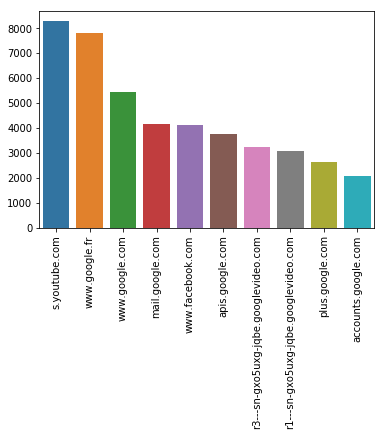

In [33]:
ax = sns.barplot(x = top10_sites, y = top10_freqs)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [44]:
with open(os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), 'rb') as SFD_pkl:
        dic_site_freq_3users = pickle.Unpickler(SFD_pkl).load()

In [4]:
#Функция для оценки времени суток
def Part_of_Day(x):
    if (x > 4) and (x <= 8):
        #'Early Morning'
        return 1
    elif (x > 8) and (x <= 12 ):
        #'Morning'
        return 2
    elif (x > 12) and (x <= 16):
        #'Noon'
        return 3
    elif (x > 16) and (x <= 20) :
        #'Eve'
        return 4
    elif (x > 20) and (x <= 24):
        #'Night'
        return 5
    elif (x <= 4):
        #'Late Night'
        return 6

In [231]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as SFD_pkl:
        Site_Freq_Dict = pickle.Unpickler(SFD_pkl).load()
  
    l = glob(path_to_csv_files+'/*.csv')
    ListDataRes = []
    
    for i, NameCsvFile in tqdm(enumerate(l)):
        user_x = pd.read_csv(NameCsvFile, header = 0, index_col = 0, parse_dates = True)
        user_x['index_site'] = user_x['site'].map(lambda x: Site_Freq_Dict[x][0])
        
        k = 0
        ListData = []

        while (k*window_size) < len(user_x):
            ListData.append([])
            
            for j in range(session_length):
                if (k*window_size+j) < len(user_x):
                    ListData[k].append(user_x['index_site'][k*window_size+j])
                else:
                    ListData[k].append(0)
            
            #Время нахождения на сайте (без учета последнего)
            for j in range(1, session_length):
                if (k*window_size+j) < len(user_x):
                    ListData[k].append(pd.Timedelta(user_x.iloc[k*window_size+j].name
                                                    -user_x.iloc[k*window_size+j-1].name).seconds)
                else:
                    ListData[k].append(0)
            #Среднее время нахождение на сайте в течении сессии
            ListData[k].append(mean(ListData[k][session_length:2*session_length-1]))
                        
            #год, месяц, день недели, час начала сессии            
            ListData[k].append(user_x.iloc[k*window_size].name.year)
            ListData[k].append(user_x.iloc[k*window_size].name.month)
            ListData[k].append(user_x.iloc[k*window_size].name.weekday())
            ListData[k].append(user_x.iloc[k*window_size].name.hour)
            
            #время суток начала сессии
            ListData[k].append(Part_of_Day(user_x.iloc[k*window_size].name.hour))
            
            for q in range(1,31):
                count = ListData[k][:session_length-1].count(q)
                Sum_times_in_site = 0
                for j in range(session_length):
                    if q == ListData[k][j]:
                        if (k*window_size+j+1) < len(user_x):
                            Sum_times_in_site +=  pd.Timedelta(user_x.iloc[k*window_size+j+1].name-
                                                        user_x.iloc[k*window_size+j].name).seconds
                #среднее время пребывания на сайте за сессию
                if count <> 0:
                    ListData[k].append(Sum_times_in_site/count)
                else:
                    ListData[k].append(0)
            #частота посещения сайта
            for q in range(1,31):
                ListData[k].append(ListData[k][:session_length-1].count(q))
            #частоты посещения сайтов фейсбука, ютуба, твиттера и гугла
            Dop_Dic = ['www.facebook.com', 'www.youtube.com', 'www.twitter.com', 'www.google.com']
                        
            for q in Dop_Dic:
                if (q in Site_Freq_Dict) or (q[4:] in Site_Freq_Dict):#без префикса www                    
                    if q in Site_Freq_Dict:
                        count += ListData[k][:session_length-1].count(Site_Freq_Dict[q][0])
                    else:
                        count += ListData[k][:session_length-1].count(Site_Freq_Dict[q[4:]][0])
                    ListData[k].append(count)
                else:
                    ListData[k].append(0)

            #добавление номера юзера
            ListData[k].append(int(NameCsvFile[-7:-4]))
            k+=1
            
        ListDataRes += ListData
        
    DataRes = pd.DataFrame(ListDataRes, columns=features)
                    
    return DataRes

In [232]:
features =  ['site_' + str(j) for j in range(1,11)] + \
            ['time_diff' + str(j) for j in range(1,10)] + \
            ['mean_time_diff','Start_Year', 'Start_Month', 'Start_Weekday', 'Start_Hour', 'Part_of_Day'] + \
            ['aver_time_top_site_' + str(j) for j in range(1,31)] + \
            ['freq_top_site_' + str(j) for j in range(1,31)] + \
            ['count_facebook', 'count_youtube', 'count_twitter', 'count_google', 'user_id']

In [233]:
new_features_3users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  features=features, session_length=10)

3it [00:00, 25.64it/s]


In [3]:
new_features_3users

NameError: name 'new_features_3users' is not defined

In [235]:
new_features_3users[['site_' + str(j) for j in range(1,11)] + \
                    ['time_diff' + str(j) for j in range(1,10)] + ['mean_time_diff']]                    

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,mean_time_diff
0,4,2,2,9,2,1,11,6,10,8,287,1184,6278,186,2,1,2,3,55,888.666667
1,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,6.666667
2,4,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,881.666667
3,3,1,2,1,2,1,1,6,7,3,287,1184,6278,186,2,1,2,3,55,888.666667
4,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,163.444444


In [236]:
new_features_3users[['site_' + str(j) for j in range(1,11)] + \
                    ['aver_time_top_site_' + str(j) for j in range(1,31)]]

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,aver_time_top_site_1,aver_time_top_site_2,...,aver_time_top_site_19,aver_time_top_site_20,aver_time_top_site_21,aver_time_top_site_22,aver_time_top_site_23,aver_time_top_site_24,aver_time_top_site_25,aver_time_top_site_26,aver_time_top_site_27,aver_time_top_site_28,aver_time_top_site_29,aver_time_top_site_30
0,4,2,2,9,2,1,11,6,10,8,1.000000,2488.0,...,0,0,0,0,0,0,0,0,0,0,0,0
1,4,1,1,1,0,0,0,0,0,0,19.333333,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,4,2,5,5,2,0,0,0,0,0,0.000000,592.0,...,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,2,1,2,1,1,6,7,3,343.250000,3140.0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,3,1,2,0,0,0,0,0,0,0,1184.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
new_features_3users[['site_' + str(j) for j in range(1,11)] + \
                    ['Start_Year', 'Start_Month', 'Start_Weekday', 'Start_Hour', 'Part_of_Day']]

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,Start_Year,Start_Month,Start_Weekday,Start_Hour,Part_of_Day
0,4,2,2,9,2,1,11,6,10,8,2013,11,4,9,Morning
1,4,1,1,1,0,0,0,0,0,0,2013,11,4,12,Morning
2,4,2,5,5,2,0,0,0,0,0,2013,11,4,9,Morning
3,3,1,2,1,2,1,1,6,7,3,2013,11,4,9,Morning
4,3,1,2,0,0,0,0,0,0,0,2013,11,4,12,Morning


In [239]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  features=features, session_length=10)

10it [01:56, 11.75s/it]


In [240]:
new_features_10users

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,time_diff1,time_diff2,...,freq_top_site_24,freq_top_site_25,freq_top_site_26,freq_top_site_27,freq_top_site_28,freq_top_site_29,freq_top_site_30,count_facebook,count_youtube,count_twitter,count_google,user_id
0,193,575,134,3,134,134,3,134,203,134,10,0,...,0,0,0,0,0,0,0,0,0,0,2,31
1,417,192,698,254,134,31,396,3673,221,55,1,0,...,0,0,0,0,0,0,0,0,0,0,0,31
2,55,3,55,55,5,294,417,336,912,55,0,14,...,0,0,0,0,0,0,0,1,1,1,2,31
3,476,3875,476,55,55,55,55,965,202,124,2,1,...,0,0,0,0,0,0,0,0,0,0,0,31
4,344,55,5,3667,258,211,4046,2323,697,2323,1,0,...,0,0,0,0,0,0,0,1,1,1,1,31
5,231,697,211,211,55,55,128,174,3986,3779,0,0,...,0,0,0,0,0,0,0,0,0,0,0,31
6,350,575,134,3,134,31,134,396,193,134,1499,0,...,0,0,0,0,0,0,0,0,0,0,1,31
7,262,3866,1638,396,55,3,55,3,202,124,2,5,...,0,0,0,0,0,0,0,0,0,0,2,31
8,55,336,106,203,1370,523,55,819,106,5,1,0,...,0,0,0,0,0,0,0,0,0,0,0,31
9,1011,350,3705,350,3750,537,609,609,537,611,3,0,...,0,0,0,0,0,0,0,0,0,0,0,31


In [237]:
#функция долго обрабатывается (наиболее узкое место связано с вызовом функции pd.Timedelta)
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  features=features, session_length=10)

150it [18:50,  5.41s/it]


In [238]:
new_features_150users

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,time_diff1,time_diff2,...,freq_top_site_24,freq_top_site_25,freq_top_site_26,freq_top_site_27,freq_top_site_28,freq_top_site_29,freq_top_site_30,count_facebook,count_youtube,count_twitter,count_google,user_id
0,1,1,4,2,1,4,1,2,1295,321,1,1,...,0,0,0,0,0,0,0,0,0,0,2,6
1,2,23,1506,1295,321,321,113,73,49,49,0,0,...,0,0,0,0,0,0,0,0,0,0,1,6
2,321,205,1,1,1,1,73,321,2,1,1,10,...,0,0,0,0,0,0,0,0,0,0,1,6
3,1,1,7145,7145,5696,7145,7145,1,35,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,6
4,1,1,76,1,58,50,58,50,83,76,4,3,...,0,0,0,0,0,0,0,0,0,0,0,6
5,50,58,94,92,50,76,76,83,92,50,0,1,...,0,0,0,0,0,0,0,0,0,0,0,6
6,58,94,58,92,76,83,50,94,94,76,0,6,...,0,0,0,0,0,0,0,0,0,0,0,6
7,83,50,58,92,58,94,50,50,76,58,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6
8,94,76,83,50,92,58,7145,76,50,58,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6
9,94,92,76,58,50,92,94,50,58,83,0,0,...,0,0,0,0,0,0,0,0,0,0,0,6


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 